File: /home/tarun/cudaEFIM/datasets/chainstore.txt, Min Util: 140000, Execution Time: 15880, Patterns: 10943
File: /home/tarun/cudaEFIM/datasets/chainstore.txt, Min Util: 150000, Execution Time: 9882, Patterns: 9741
File: /home/tarun/cudaEFIM/datasets/chainstore.txt, Min Util: 160000, Execution Time: 9045, Patterns: 8782
File: /home/tarun/cudaEFIM/datasets/chainstore.txt, Min Util: 170000, Execution Time: 9174, Patterns: 7931
File: /home/tarun/cudaEFIM/datasets/chainstore.txt, Min Util: 180000, Execution Time: 8615, Patterns: 7168
File: /home/tarun/cudaEFIM/datasets/chainstore.txt, Min Util: 190000, Execution Time: 7968, Patterns: 6541
File: /home/tarun/cudaEFIM/datasets/chainstore.txt, Min Util: 200000, Execution Time: 7551, Patterns: 6037
File: /home/tarun/cudaEFIM/datasets/chainstore.txt, Min Util: 140000, Execution Time: 59642, Patterns: 10943
File: /home/tarun/cudaEFIM/datasets/chainstore.txt, Min Util: 150000, Execution Time: 49919, Patterns: 9741
File: /home/tarun/cudaEFIM/datas

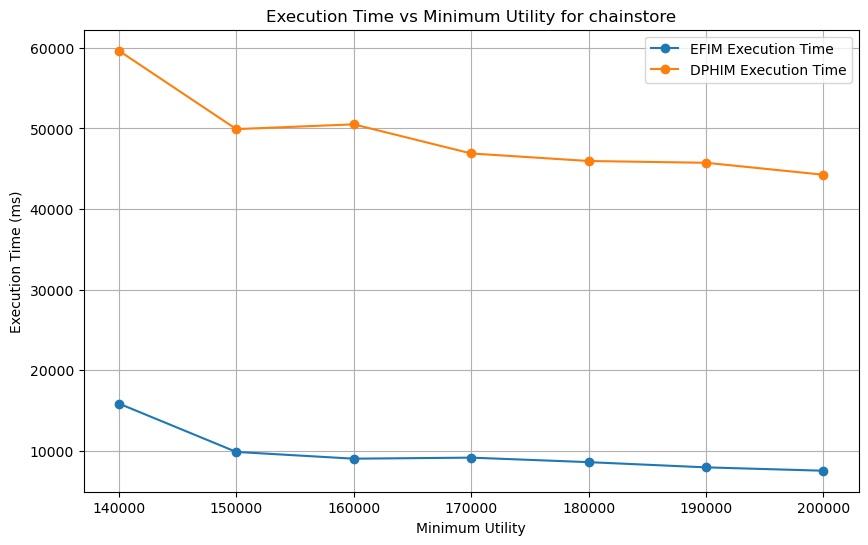

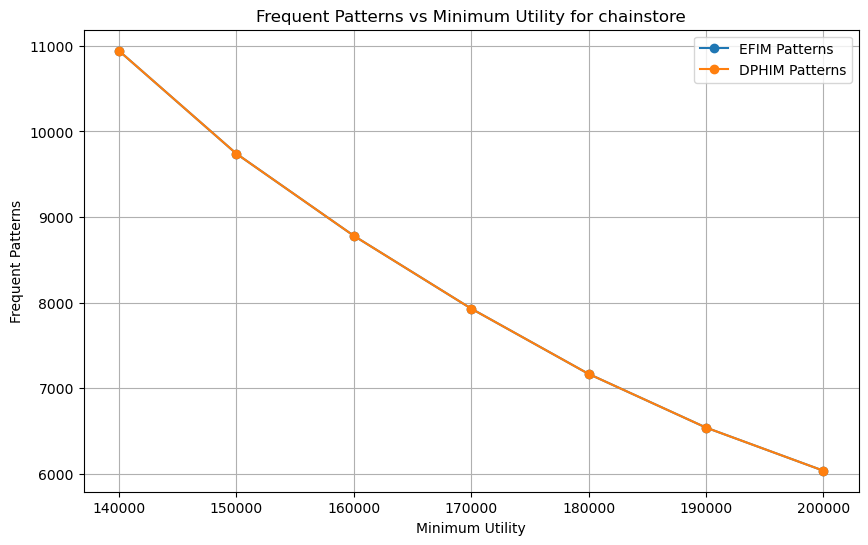

In [2]:
import subprocess
import pandas as pd
import os
import matplotlib.pyplot as plt

# Initialize a consolidated DataFrame
columns = ["Algorithm", "File", "Minimum_Utility", "Execution_Time", "Frequent_Patterns"]
results_df = pd.DataFrame(columns=columns)

def save_results():
    """Save results DataFrame to CSV."""
    results_df.to_csv("combined_results.csv", index=False)

def run_efim(process_data):
    global results_df
    for entry in process_data:
        file_path, min_utilities = entry
        for min_util in min_utilities:
            command = [
                "/home/tarun/cudaEFIM/build/efim",
                "-f", file_path,
                "-o", "output.txt",
                "-s", "space",
                "-m", str(min_util),
                "-M", "GPU"
            ]
            try:
                result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
                output = result.stdout

                execution_time = None
                frequent_patterns = None

                for line in output.splitlines():
                    if "Execution time:" in line:
                        execution_time = float(line.split("Execution time:")[-1].strip().replace("s", ""))
                        execution_time = int(execution_time * 1000)  # Convert to ms
                    elif "Frequent Patterns:" in line:
                        frequent_patterns = int(line.split("Frequent Patterns:")[-1].strip())

                print(f"File: {file_path}, Min Util: {min_util}, Execution Time: {execution_time}, Patterns: {frequent_patterns}")
                new_entry = {
                    "Algorithm": "EFIM",
                    "File": os.path.splitext(os.path.basename(file_path))[0],
                    "Minimum_Utility": min_util,
                    "Execution_Time": execution_time,
                    "Frequent_Patterns": frequent_patterns
                }
                results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
                save_results()
            except Exception as e:
                print(f"Error running EFIM: {e}")

def run_dphim(process_data):
    global results_df
    for entry in process_data:
        file_path, min_utilities = entry
        for min_util in min_utilities:
            command = [
                "/home/tarun/dphim/build/run",
                "-i", file_path,
                "-m", str(min_util),
                "-s", "local",
                "--mp",
                "-t", "14"
            ]
            try:
                result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
                output = result.stdout

                execution_time = None
                frequent_patterns = None

                for line in output.splitlines():
                    if "Total time ~:" in line:
                        execution_time = int(line.split("Total time ~:")[-1].strip().split(" ")[0])  # Convert to ms
                    elif "High utility itemsets count:" in line:
                        frequent_patterns = int(line.split("High utility itemsets count:")[-1].strip())

                print(f"File: {file_path}, Min Util: {min_util}, Execution Time: {execution_time}, Patterns: {frequent_patterns}")
                new_entry = {
                    "Algorithm": "DPHIM",
                    "File": os.path.splitext(os.path.basename(file_path))[0],
                    "Minimum_Utility": min_util,
                    "Execution_Time": execution_time,
                    "Frequent_Patterns": frequent_patterns
                }
                results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
                save_results()
            except Exception as e:
                print(f"Error running DPHIM: {e}")

def plot_results(results_df, file_name):
    filtered_df = results_df[results_df['File'] == os.path.splitext(file_name)[0]]

    # Plot Execution Time vs Minimum Utility
    plt.figure(figsize=(10, 6))
    for algorithm in filtered_df["Algorithm"].unique():
        subset = filtered_df[filtered_df["Algorithm"] == algorithm]
        plt.plot(subset["Minimum_Utility"], subset["Execution_Time"], marker='o', label=f"{algorithm} Execution Time")
    plt.title(f"Execution Time vs Minimum Utility for {os.path.splitext(file_name)[0]}")
    plt.xlabel("Minimum Utility")
    plt.ylabel("Execution Time (ms)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{os.path.splitext(file_name)[0]}_execution_time.svg")
    plt.show()

    # Plot Frequent Patterns vs Minimum Utility
    plt.figure(figsize=(10, 6))
    for algorithm in filtered_df["Algorithm"].unique():
        subset = filtered_df[filtered_df["Algorithm"] == algorithm]
        plt.plot(subset["Minimum_Utility"], subset["Frequent_Patterns"], marker='o', label=f"{algorithm} Patterns")
    plt.title(f"Frequent Patterns vs Minimum Utility for {os.path.splitext(file_name)[0]}")
    plt.xlabel("Minimum Utility")
    plt.ylabel("Frequent Patterns")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{os.path.splitext(file_name)[0]}_patterns.svg")
    plt.show()

# Example usage
process_data = [
    ["/home/tarun/cudaEFIM/datasets/chainstore.txt", [140000, 150000, 160000, 170000, 180000, 190000, 200000]],
]

# Run EFIM and DPHIM
run_efim(process_data)
run_dphim(process_data)

# Plot results for a specific file
plot_results(results_df, "chainstore.txt")
